In [1]:
import os
import pandas as pd
os.chdir('/home/clee/Impaye')
os.path.abspath(os.getcwd())
df = pd.read_csv("data20230717_v2.csv", sep=";", decimal=",", encoding="latin9", low_memory=False)
df.shape

(41907, 20)

In [2]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [3]:
#data["IMPAYE"].value_counts()/data.shape[0]*100
df["IMPAYE"].value_counts()/df.shape[0]*100

0    63.294915
1    36.705085
Name: IMPAYE, dtype: float64

In [4]:
df.SEXE = df.SEXE.astype(str)
df.DEPARTEMENT = df.DEPARTEMENT.astype(str)
df.FRACTIONNEMENT = df.FRACTIONNEMENT.astype(str)
df.drop(df[df.REGIME_OBLIGATOIRE.isna()].index, inplace=True)

In [5]:
import pandas as pd

def get_encoding_methods(df):
    """
    Determines the encoding method to use for each object column in the given pandas DataFrame.
    Columns with more than 10 unique values are one-hot encoded, while columns with
    10 or fewer unique values are frequency encoded.
    
    Args:
    df (pandas DataFrame): The DataFrame to be encoded.
    
    Returns:
    dict: A dictionary mapping object column names to encoding methods ('one-hot' or 'frequency').
    """
    encoding_methods = {}
    for col in df.select_dtypes(include='object').columns:
        print(col, len(df[col].unique()))
        if len(df[col].unique()) <= 10:
            encoding_methods[col] = 'one-hot'
        else:
            encoding_methods[col] = 'frequency'
    return encoding_methods
X_cats = get_encoding_methods(df)
X_cats

PRODUIT 11
CANAL_VENTE 4
GAR_PRINC 65
FRACTIONNEMENT 4
STATUT_CONTRAT 5
SEXE 2
STATUT_MARITAL 3
REGIME_OBLIGATOIRE 6
DEPARTEMENT 99
TRANCHE_AGE 5


{'PRODUIT': 'frequency',
 'CANAL_VENTE': 'one-hot',
 'GAR_PRINC': 'frequency',
 'FRACTIONNEMENT': 'one-hot',
 'STATUT_CONTRAT': 'one-hot',
 'SEXE': 'one-hot',
 'STATUT_MARITAL': 'one-hot',
 'REGIME_OBLIGATOIRE': 'one-hot',
 'DEPARTEMENT': 'frequency',
 'TRANCHE_AGE': 'one-hot'}

In [6]:

def preprocessing(df):
    data = df.drop(columns=["PERIODE","CONTRAT","DATE_NAISSANCE","VILLE","BANQUE","ANNEE","CODE_COMMUNE"])
    data.SEXE = data.SEXE.astype(str)
    data.DEPARTEMENT = data.DEPARTEMENT.astype(str)
    data.FRACTIONNEMENT = data.FRACTIONNEMENT.astype(str)
    data.drop(data[data.REGIME_OBLIGATOIRE.isna()].index, inplace=True)
    X_cats = get_encoding_methods(data)

In [7]:
#df.drop(columns=["prime_cat"],inplace = True, axis=1)

In [8]:
data_num = df.drop(columns=list(X_cats.keys()),axis=1)
X_num = list(data_num.columns[1:])
X_num_dist = ["NB_PRIMES_REGLEES","NB_BENEFICIAIRES","NB_PRIMES_RETARD","MULTI_DETENTION"]
X_num_cont = [x for x in X_num if x not in X_num_dist]
X_num = X_num_cont+X_num_dist

In [9]:
X_num

['PRIME_ANNUELLE_TTC',
 'TAUX_COUVERTURE',
 'TAUX_REVALORISATION',
 'DELAI_EFFET',
 'DELAI_EFFET_GAR',
 'NB_PRIMES_REGLEES',
 'NB_BENEFICIAIRES',
 'NB_PRIMES_RETARD',
 'MULTI_DETENTION']

In [10]:
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from collections import Counter


X = df.iloc[:,1:]
y = df.iloc[:,0]

#y = data.pop("IMPAYE")
#X = data


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True,drop=True)

In [12]:
X_onehot = [k for k, v in X_cats.items() if v == 'one-hot']
X_freq = [k for k, v in X_cats.items() if v == 'frequency']

## Minmax Scaling pour variable continues

In [14]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_minmax = minmax.fit_transform(X_train[X_num_cont])
train_minmax_df = pd.DataFrame(train_minmax, columns = X_num_cont)

test_minmax = minmax.transform(X_test[X_num_cont])
test_minmax_df = pd.DataFrame(test_minmax, columns = X_num_cont)

## Onehot et Target pour categorielle

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
import pandas as pd

# define the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_onehot),
        ('target',  TargetEncoder(), X_freq)
    ])

# fit the transformers on the training set and transform both training and testing sets
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

col_names = preprocessor.get_feature_names()

# create new DataFrames for the processed training and testing sets
train_cat_df = pd.DataFrame(X_train_processed, columns=col_names)
test_cat_df = pd.DataFrame(X_test_processed, columns=col_names)


/opt/anaconda3/envs/etl_clee/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/etl_clee/lib/python3.7/site-packages/category_encoders/utils.py:361: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  category=FutureWarning)


In [16]:
train_dist_df = X_train[X_num_dist]
test_dist_df = X_test[X_num_dist]
X_train = pd.concat([train_minmax_df, train_dist_df, train_cat_df], axis=1)
X_test = pd.concat([test_minmax_df, test_dist_df, test_cat_df], axis= 1)

In [17]:
X_train.head()

,PRIME_ANNUELLE_TTC,TAUX_COUVERTURE,TAUX_REVALORISATION,DELAI_EFFET,DELAI_EFFET_GAR,NB_PRIMES_REGLEES,NB_BENEFICIAIRES,NB_PRIMES_RETARD,MULTI_DETENTION,onehot__x0_COURTAGE,onehot__x0_ESPACE_CLIENT,onehot__x0_RCS,onehot__x0_VDI,onehot__x1_1,onehot__x1_12,onehot__x1_2,onehot__x1_4,onehot__x2_CONTRAT,onehot__x2_CONTRAT_ATTENTE_PIECES,onehot__x2_DEVIS,onehot__x2_MIS_EN_DEMEURE,onehot__x2_SUSPENDU,onehot__x3_0,onehot__x3_1,onehot__x4_DUO,onehot__x4_FAMILLE,onehot__x4_SOLO,onehot__x5_ALSACE_MOSELLE,onehot__x5_AMEXA,onehot__x5_MONACO,onehot__x5_REGIME_GENERAL,onehot__x5_SALARIE_AGRICOLE,onehot__x5_TNS,onehot__x6_26-35,onehot__x6_36-45,onehot__x6_46-55,onehot__x6_Moins 25,onehot__x6_Plus 55,target__PRODUIT,target__GAR_PRINC,target__DEPARTEMENT
0,0.128274,0.609375,0.375,0.176263,0.110051,21,1,0,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.225402,0.216180,0.299180
1,0.028225,0.934896,0.375,0.146886,0.091709,5,1,0,2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.464233,0.474709,0.375000
2,0.066198,0.609375,0.375,0.163337,0.101981,1,1,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.464233,0.474709,0.340515
3,0.150365,0.902181,0.875,0.172738,0.107850,6,2,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.391710,0.386095,0.365019
4,0.058372,0.609375,0.375,0.141011,0.088041,12,1,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.391710,0.395159,0.352778


In [18]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import lightgbm as lgb


def compute_lc(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1):
    print("Starting at %s...."%datetime.now())
    #Définir la métrique d'évaluation
    scorer = make_scorer(f1_score)

    #Calculer les scores d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='f1', train_sizes=train_sizes,n_jobs=n_jobs)

    # Calculer les moyennes et les écart-types des scores d'apprentissage
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Tracer les courbes d'apprentissage
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Train score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Test score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.xlabel('Training examples')
    plt.ylabel('F1-score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Learning Curve')
    plt.show()
    print("Ended at %s "%datetime.now())

In [19]:
from sklearn.metrics import classification_report
def fit_report(model, X_train, y_train, X_test, y_test):
    print("Starting at %s "%datetime.now())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Ended at %s "%datetime.now())
    print(classification_report(y_test, y_pred))


## --------------

In [20]:
import lightgbm as lgb
def get_features_lgb(clf_lgb, K, X):
    importances = {}
    for feature_name, importance in zip(X.columns, clf_lgb.feature_importances_):
        importances[feature_name] = importance
    importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
    return list(importances.keys())[0:K]


Starting at 2025-03-05 17:44:39.733898....


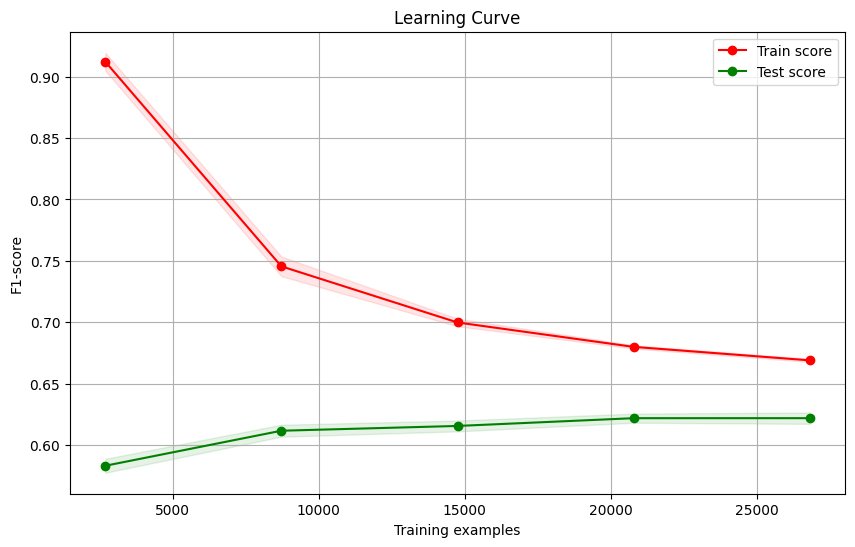

Ended at 2025-03-05 17:44:42.785194 
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      5263
           1       0.75      0.52      0.62      3119

    accuracy                           0.76      8382
   macro avg       0.76      0.71      0.72      8382
weighted avg       0.76      0.76      0.75      8382

Starting at 2025-03-05 17:44:42.999231....


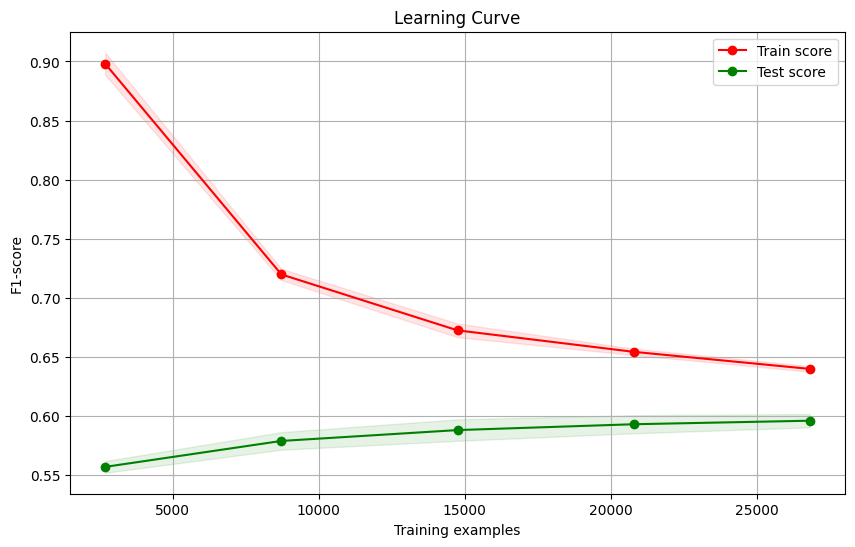

Ended at 2025-03-05 17:44:44.751300 
              precision    recall  f1-score   support

           0       0.75      0.88      0.81      5263
           1       0.71      0.50      0.59      3119

    accuracy                           0.74      8382
   macro avg       0.73      0.69      0.70      8382
weighted avg       0.74      0.74      0.73      8382

Starting at 2025-03-05 17:44:44.915490....


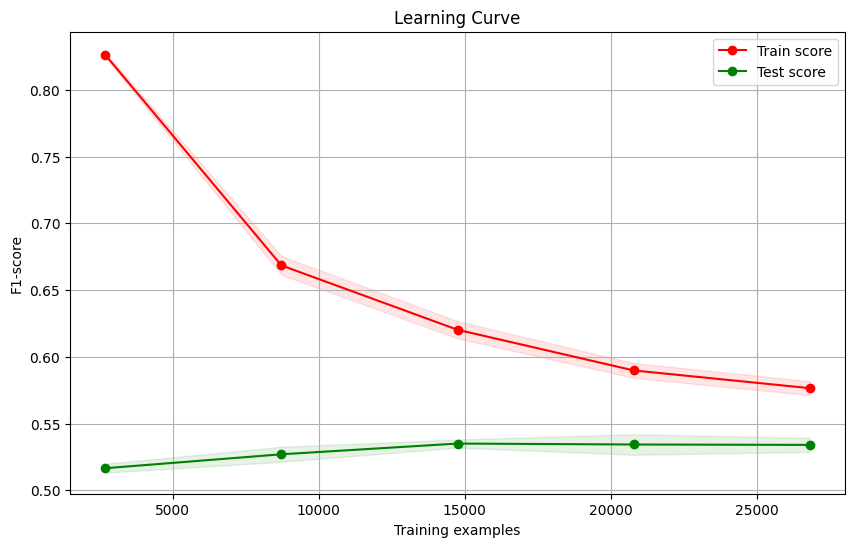

Ended at 2025-03-05 17:44:46.553584 
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      5263
           1       0.71      0.42      0.53      3119

    accuracy                           0.72      8382
   macro avg       0.72      0.66      0.67      8382
weighted avg       0.72      0.72      0.70      8382

Starting at 2025-03-05 17:44:46.690575....


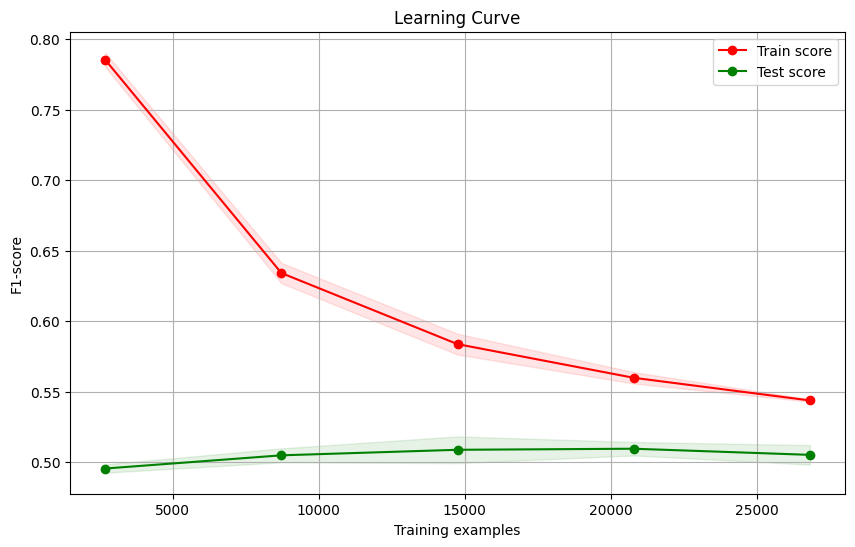

Ended at 2025-03-05 17:44:48.203403 
              precision    recall  f1-score   support

           0       0.71      0.91      0.80      5263
           1       0.70      0.38      0.49      3119

    accuracy                           0.71      8382
   macro avg       0.71      0.64      0.64      8382
weighted avg       0.71      0.71      0.68      8382

Starting at 2025-03-05 17:44:48.328803....


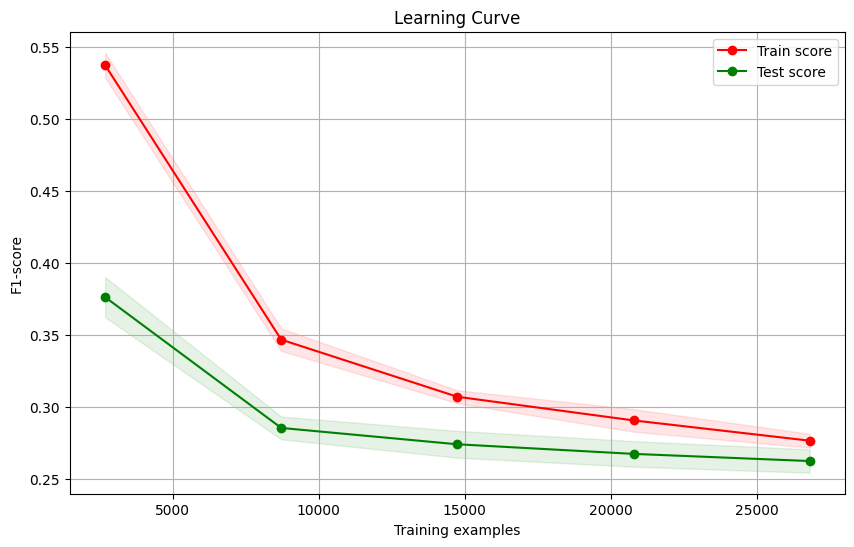

Ended at 2025-03-05 17:44:49.592035 
              precision    recall  f1-score   support

           0       0.66      0.99      0.79      5263
           1       0.86      0.15      0.26      3119

    accuracy                           0.67      8382
   macro avg       0.76      0.57      0.52      8382
weighted avg       0.74      0.67      0.59      8382



In [21]:
import lightgbm as lgb

def report(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

clf_lgb = lgb.LGBMClassifier(n_jobs=-1, random_state=42)
# lgb_ada = lgb.LGBMClassifier(is_unbalance=True, n_jobs=-1, random_state=42, verbose=-100)
#lgb_sm = lgb.LGBMClassifier(is_unbalance=True, n_jobs=-1, random_state=42, verbose=-100)

compute_lc(clf_lgb, X_train, y_train)
clf_lgb.fit(X_train, y_train)
report(clf_lgb)

X_lgb_10 = get_features_lgb(clf_lgb, 10, X_train)
compute_lc(clf_lgb, X_train[X_lgb_10], y_train)
model_lgb_10 = clf_lgb.fit(X_train[X_lgb_10], y_train)
report(model_lgb_10, X_test = X_test[X_lgb_10])

X_lgb_7 = get_features_lgb(clf_lgb, 7, X_train)
compute_lc(clf_lgb, X_train[X_lgb_7], y_train)
clf_lgb.fit(X_train[X_lgb_7], y_train)
report(clf_lgb, X_test = X_test[X_lgb_7])

X_lgb_5 = get_features_lgb(clf_lgb, 5, X_train)
compute_lc(clf_lgb, X_train[X_lgb_5], y_train)
clf_lgb.fit(X_train[X_lgb_5], y_train)
report(clf_lgb, X_test = X_test[X_lgb_5])

X_lgb_3 = get_features_lgb(clf_lgb, 3, X_train)
compute_lc(clf_lgb, X_train[X_lgb_3], y_train)
clf_lgb.fit(X_train[X_lgb_3], y_train)
report(clf_lgb, X_test = X_test[X_lgb_3])


In [70]:
# import lightgbm as lgb
# #lgb_tuned = lgb.LGBMClassifier(bagging_fraction = 0.8, feature_fraction = 0.8, is_unbalance=False, learning_rate=0.05, max_depth=29, min_data_in_leaf=32, n_estimators=295, num_leaves=18, random_state=42, verbosity=-1)
# compute_lc(lgb_tuned, X_train, y_train)
# fit_report(lgb_tuned, X_train, y_train,X_test,y_test)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging

In [26]:
list_X = X_train.columns.tolist()
len(list_X)

41

In [27]:
import eli5
clf_lgb = lgb.LGBMClassifier(n_jobs=-1, random_state=42)
clf_lgb.fit(X_train, y_train)
eli5.show_weights(clf_lgb)

Weight,Feature
0.2291,NB_PRIMES_REGLEES
0.2118,TAUX_REVALORISATION
0.1314,onehot__x2_MIS_EN_DEMEURE
0.0869,target__PRODUIT
0.0606,DELAI_EFFET
0.0514,target__GAR_PRINC
0.0432,onehot__x6_Plus_55
0.0422,PRIME_ANNUELLE_TTC
0.0374,MULTI_DETENTION
0.0227,target__DEPARTEMENT


In [67]:
import shap
import eli5

explainer = shap.Explainer(clf_lgb)
shap_values = explainer(X_test)

shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test.iloc[0][X_lgb_10])
shap.force_plot(base_value=explainer.expected_value[0], shap_values = shap_values[0,:,0].values, features=X_test.iloc[0].values,feature_names = list_X)


In [29]:
eli5.show_prediction(clf_lgb, X_test.iloc[1], feature_names=list_X)

In [30]:
eli5.show_prediction(clf_lgb, X_test.iloc[3], feature_names=list_X)

In [31]:
for i in range(0,3):
    print(X_test.NB_PRIMES_REGLEES.iloc[i])

11
1
14


In [32]:
eli5.show_prediction(lgb_tuned, X_test.iloc[2], feature_names=list_X)

In [33]:
data_2 = pd.read_csv("new_data.csv",sep=";", decimal = ",", encoding="latin9")
data_2.SEXE = data_2.SEXE.astype(str)
data_2.DEPARTEMENT = data_2.DEPARTEMENT.astype(str)
data_2.FRACTIONNEMENT = data_2.FRACTIONNEMENT.astype(str)
data_2.drop(data_2[data_2.REGIME_OBLIGATOIRE.isna()].index, inplace=True)

X_cats_2 = get_encoding_methods(data_2)

data_num_2 = df.drop(columns=list(X_cats.keys()),axis=1)
#data_2.drop(columns=X_to_drop,inplace=True, axis=1)

X_2 = data_2.iloc[:,1:]
y_2 = data_2.iloc[:,0]

pred_minmax = minmax.transform(X_2[X_num_cont])
pred_minmax_df = pd.DataFrame(pred_minmax, columns = X_num_cont)
X_2_processed = preprocessor.transform(X_2)

col_names = preprocessor.get_feature_names()

# create new DataFrames for the processed training and testing sets
pred_cat_df = pd.DataFrame(X_2_processed, columns=col_names)
pred_dist_df = X_2[X_num_dist]
X_2 = pd.concat([pred_minmax_df, pred_dist_df, pred_cat_df], axis=1)


PRODUIT 10
CANAL_VENTE 4
GAR_PRINC 62
FRACTIONNEMENT 4
STATUT_CONTRAT 4
SEXE 2
STATUT_MARITAL 3
REGIME_OBLIGATOIRE 6
DEPARTEMENT 99
TRANCHE_AGE_CHOM 3
TRANCHE_AGE 5


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.


In [34]:
def model_score(clf, list_X):
    import lightgbm as lgb
    from sklearn.metrics import accuracy_score
    compute_lc(clf, X_train[list_X], y_train)
    model = clf.fit(X_train[list_X], y_train)
    report(model, X_test = X_test[list_X])
    lgb = model
    result = lgb.score(X_2[list_X], y_2)
    print(result)

    y_pred = lgb.predict(X_2[list_X])
    acc = accuracy_score(y_2, y_pred)
    print(acc)

['onehot__x1_2', 'onehot__x1_1', 'onehot__x0_ESPACE_CLIENT', 'NB_PRIMES_RETARD', 'onehot__x5_SALARIE_AGRICOLE', 'onehot__x5_AMEXA', 'onehot__x5_MONACO', 'onehot__x2_SUSPENDU', 'onehot__x2_DEVIS']
Starting at 2025-03-05 17:44:59.915001....


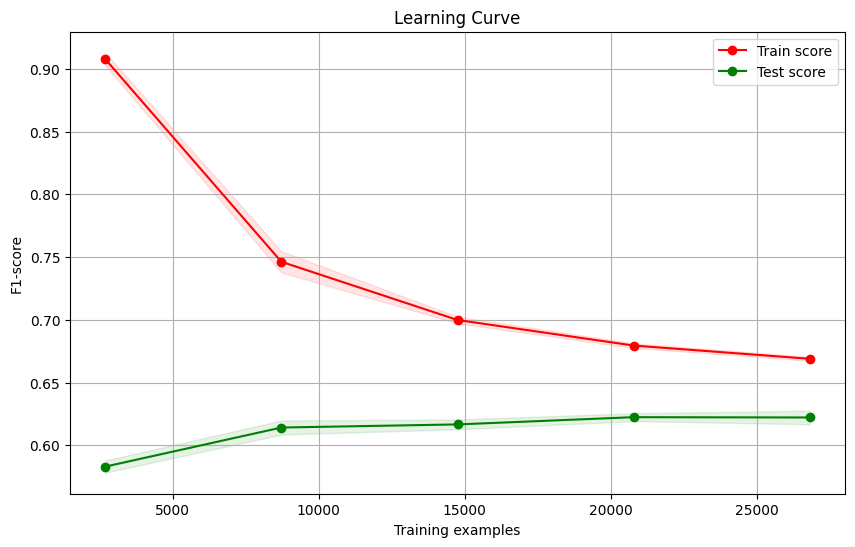

Ended at 2025-03-05 17:45:01.909956 
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      5263
           1       0.75      0.52      0.62      3119

    accuracy                           0.76      8382
   macro avg       0.76      0.71      0.72      8382
weighted avg       0.76      0.76      0.75      8382

0.7139510422642953
0.7139510422642953


In [35]:
import eli5
from eli5.sklearn import explain_weights
import lightgbm as lgb
from sklearn.metrics import accuracy_score

clf_lgb = lgb.LGBMClassifier(n_jobs=-1, random_state=42)
model = clf_lgb.fit(X_train, y_train)
weights = eli5.explain_weights_df(model, feature_names=list_X)
negative_features = weights["feature"][weights["weight"] <= 0].tolist()
new_X_list = X_train.loc[:, ~X_train.columns.isin(negative_features)].columns.tolist()
print(negative_features)
model_score(clf_lgb, new_X_list)

Starting at 2025-03-05 17:45:02.234040....


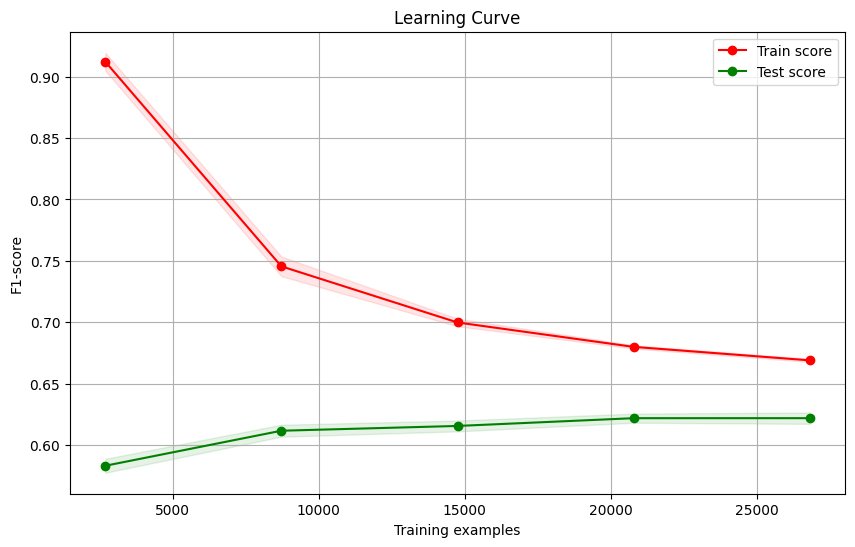

Ended at 2025-03-05 17:45:04.290103 
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      5263
           1       0.75      0.52      0.62      3119

    accuracy                           0.76      8382
   macro avg       0.76      0.71      0.72      8382
weighted avg       0.76      0.76      0.75      8382

0.7139510422642953
0.7139510422642953


In [36]:
X_list = X_2.columns.tolist()
len(X_list)
model_score(clf_lgb, X_list)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

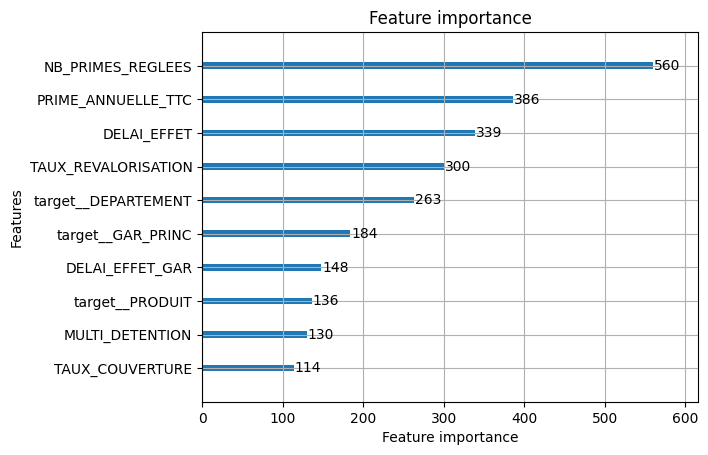

In [37]:
import lightgbm as lgb
lgb.plot_importance(model, importance_type='split', max_num_features=10)

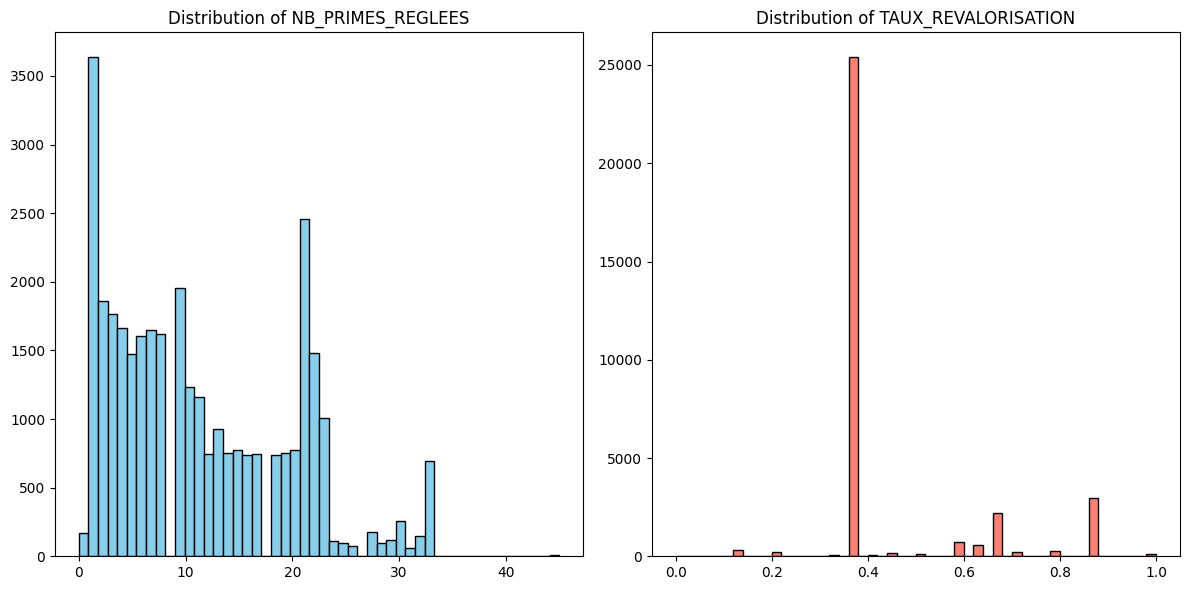

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(X_train['NB_PRIMES_REGLEES'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of NB_PRIMES_REGLEES')

plt.subplot(1, 2, 2)
plt.hist(X_train['TAUX_REVALORISATION'], bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of TAUX_REVALORISATION')

plt.tight_layout()
plt.show()
